# Scenario "Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation"



| Data Set | Train trjectories | Test trajectories | Conditions      | Fault Mode                             |
|----------|:-----------------:|------------------:|-----------------|----------------------------------------|
| FD001    |        100        |               100 | ONE (Sea Level) | ONE (HPC Degradation)                  |
| FD002    |        260        |               259 | SIX             | ONE (HPC Degradation)                  |
| FD003    |        100        |               100 | ONE (Sea Level) | TWO (HPC Degradation, Fan Degradation) |
| FD004    |        248        |               249 | SIX             | TWO (HPC Degradation, Fan Degradation) |



## Experimental Scenario

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine ñ i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

| Column| Train trjectories | 
|----------|:-----------------|
| 1    |        unit number        |   
| 2    |        time, in cycles        |     
| 3    |        operational setting 1        |   
| 4    |        operational setting 2        |             
| 5    |        operational setting 3        |           
| 6    |        sensor measurement  1        |              
| 7    |        sensor measurement  2        |             
| 26   |        sensor measurement  3        |              


References: 

1. A. Saxena, K. Goebel, D. Simon, and N. Eklund, "Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation", in the Proceedings of the Ist International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008., retrieved feb. 2016
2. NASA Ames Prognostics data repository, retrieved feb. 2016, http://ti.arc.nasa.gov/tech/dash/pcoe/prognostic-data-repository/
3. [Major Challenges in Prognostics: Study on Benchmarking Prognostics Datasets](https://www.phmsociety.org/sites/phmsociety.org/files/phm_submission/2012/phmce_12_004.pdf), O. F. Eker1, F. Camci, and I. K. Jennions1, retrieved feb. 2016
4. [Big Data Analytics for eMaintenance : Modeling of high-dimensional data streams.](	
http://goo.gl/kgvoMt) / Zhang, Liangwei.
Luleå : Luleå tekniska universitet, 2015. 46 p. (Licentiate thesis / Luleå University of Technology).
Publication: Research › Licentiate thesis, retrieved feb. 2016
5. Microsoft Cortana example with the same dataset, retrieved feb. 2016 [Link](https://gallery.cortanaanalytics.com/Collection/Predictive-Maintenance-Template-3?share=1)
6. H2o.io example with the same dataset, retrieved feb. 2016
[Link](https://github.com/h2oai/h2o-tutorials/blob/master/tutorials/python-munging-modeling-pipelines/Munging-Modeling-Pipelines-Using-H2O-Pipelines.ipynb) [Presentation](https://www.youtube.com/watch?v=KqLXFglgNqk)
7. Advanced Analytics with Spark - Patterns for Learning from Data at Scale By Sandy Ryza, Uri Laserson, Sean Owen, Josh Wills. [Link](http://shop.oreilly.com/product/0636920035091.do) [Examples](https://github.com/sryza/aas)



## intuition of solution 

1. Do visual inspection of the data to enable feature extration and algorithm selection 
2. Train Machine learning model (ML) 
3. Run model to predict classes 
4. Ecaluate model with quality metrics 
5. Change weights on features (coeffients) 


![img](https://raw.githubusercontent.com/combient/tedsds/master/images/ML_Classification_Workflow.png?token=AAJNseI3OcRl1KYDV_ahYL1IGnIjagcBks5W9Qa5wA%3D%3D)


![img](https://raw.githubusercontent.com/combient/tedsds/master/images/datatable.png?token=AAJNsecXdg4OgkpYCSV9c3okmgQjzT2gks5W8oqIwA%3D%3D)

In [2]:
import findspark
findspark.init()
import pyspark
#sc = pyspark.SparkContext()

In [3]:
# Setup the column names of the training file
index_columns_names =  ["id","cycle"]
operational_settings_columns_names = ["setting"+str(i) for i in range(1,4)]
sensor_measure_columns_names =["s"+str(i) for i in range(1,22)]
sensor_measure_meancolumns_names =["a"+str(i) for i in range(1,22)]
sensor_measure_sdeccolumns_names =["sd"+str(i) for i in range(1,22)]

input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

# And the name of the to be engineered target variable
dependent_var = ['rul']

In [5]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *

sqlContext = SQLContext(sc)

scaledDF = sqlContext.read.parquet('/share/tedsds/output')
scaledDF.describe('setting1','s1','a1','sd1','rul', 's7', 's12', 's20').toPandas()

summary                setting1                 s1                 a1  \
0   count                   13096              13096              13096   
1    mean  -1.1178985949908365E-5  518.6699999999987  518.6699999999987   
2  stddev    0.002202685080807614                0.0                0.0   
3     min                 -0.0082             518.67             518.67   
4     max                  0.0078             518.67             518.67   

     sd1                 rul                  s7                 s12  \
0  13096               13096               13096               13096   
1    0.0   75.83651496640195   553.7575229077578   521.7477237324374   
2    0.0  53.057749469912444  0.6812861095937863  0.5596267536793479   
3    0.0                   0              550.88              519.38   
4    0.0                 302              555.84              523.76   

                   s20  
0                13096  
1   38.892501527183875  
2  0.14168075530496127  
3                38.31  
4                39.41

In [6]:
scaledDF.printSchema()

root
 |-- id: integer (nullable = true)
 |-- cykle: integer (nullable = true)
 |-- setting1: double (nullable = true)
 |-- setting2: double (nullable = true)
 |-- setting3: double (nullable = true)
 |-- s1: double (nullable = true)
 |-- s2: double (nullable = true)
 |-- s3: double (nullable = true)
 |-- s4: double (nullable = true)
 |-- s5: double (nullable = true)
 |-- s6: double (nullable = true)
 |-- s7: double (nullable = true)
 |-- s8: double (nullable = true)
 |-- s9: double (nullable = true)
 |-- s10: double (nullable = true)
 |-- s11: double (nullable = true)
 |-- s12: double (nullable = true)
 |-- s13: double (nullable = true)
 |-- s14: double (nullable = true)
 |-- s15: double (nullable = true)
 |-- s16: double (nullable = true)
 |-- s17: double (nullable = true)
 |-- s18: double (nullable = true)
 |-- s19: double (nullable = true)
 |-- s20: double (nullable = true)
 |-- s21: double (nullable = true)
 |-- maxcykle: integer (nullable = true)
 |-- rul: integer (nullable = true)

In [7]:
fraction = 1000.0 / scaledDF.count()
pf = scaledDF.select(dependent_var+operational_settings_columns_names+sensor_measure_columns_names).sample(fraction=fraction, withReplacement=False, seed=123456).toPandas()



In [8]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set() 

def labels(x, y, *axes):
    for axis in axes:
        if x: axis.set_xlabel(x)
        if y: axis.set_ylabel(y)


/opt/rh/python27/root/usr/lib64/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


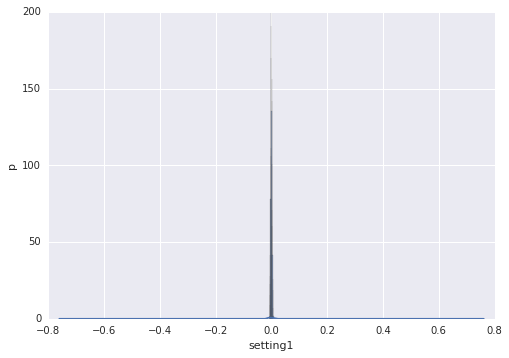

In [9]:
ax = sns.distplot(pf[["setting1"]])
labels("setting1", "p", ax)


In [10]:
pf_corr = pf.corr(method='pearson')
pf_corr

rul      setting1      setting2  setting3            s1  \
rul       1.000000e+00 -3.092092e-02  4.126593e-02       NaN -1.136067e-16   
setting1 -3.092092e-02  1.000000e+00 -4.123676e-02       NaN -2.827801e-18   
setting2  4.126593e-02 -4.123676e-02  1.000000e+00       NaN -3.309684e-17   
setting3           NaN           NaN           NaN       NaN           NaN   
s1       -1.136067e-16 -2.827801e-18 -3.309684e-17       NaN  1.000000e+00   
s2       -2.829646e-01  3.095572e-02 -3.648315e-03       NaN  2.792527e-12   
s3       -2.649027e-01 -3.209453e-03 -4.149645e-02       NaN -3.981369e-13   
s4       -3.950620e-01  1.694105e-02 -5.715926e-02       NaN  2.453903e-13   
s5       -2.460876e-16 -2.453563e-17  4.136960e-17       NaN -1.000000e+00   
s6       -7.213083e-02 -7.773266e-03 -7.454944e-02       NaN -1.521827e-10   
s7        3.550885e-01 -2.474134e-02  5.622883e-02       NaN -9.792309e-15   
s8       -2.770298e-01  4.794513e-02 -1.924857e-02       NaN -1.020100e-10   
s9       -1.564315e-01 -4.504346e-02 -1.260263e-02       NaN  1.031745e-14   
s10       4.495118e-16  5.936501e-17 -7.968879e-17       NaN  1.000000e+00   
s11      -3.953962e-01  2.718619e-02 -8.207219e-02       NaN -1.562845e-13   
s12       3.657678e-01 -4.301092e-02  5.219477e-02       NaN  2.038928e-13   
s13      -2.959790e-01  4.377122e-02 -6.551620e-02       NaN -1.167644e-10   
s14      -8.744462e-02 -5.972234e-02  3.952524e-03       NaN  4.654923e-13   
s15      -3.301099e-01 -9.197506e-03 -4.442407e-02       NaN  2.665994e-14   
s16      -4.495118e-16 -5.936501e-17  7.968879e-17       NaN -1.000000e+00   
s17      -2.708838e-01 -3.461766e-02 -3.263109e-02       NaN -2.210822e-14   
s18                NaN           NaN           NaN       NaN           NaN   
s19                NaN           NaN           NaN       NaN           NaN   
s20       3.115364e-01 -2.375597e-02  3.470742e-02       NaN -9.593017e-14   
s21       3.395457e-01  9.943719e-04  9.166500e-02       NaN -1.160991e-13   

                    s2            s3            s4            s5  \
rul      -2.829646e-01 -2.649027e-01 -3.950620e-01 -2.460876e-16   
setting1  3.095572e-02 -3.209453e-03  1.694105e-02 -2.453563e-17   
setting2 -3.648315e-03 -4.149645e-02 -5.715926e-02  4.136960e-17   
setting3           NaN           NaN           NaN           NaN   
s1        2.792527e-12 -3.981369e-13  2.453903e-13 -1.000000e+00   
s2        1.000000e+00  3.942732e-01  5.259501e-01 -2.792402e-12   
s3        3.942732e-01  1.000000e+00  5.172692e-01  3.981930e-13   
s4        5.259501e-01  5.172692e-01  1.000000e+00 -2.453944e-13   
s5       -2.792402e-12  3.981930e-13 -2.453944e-13  1.000000e+00   
s6        1.202321e-01  1.249258e-01  1.616164e-01  1.521827e-10   
s7       -5.048559e-01 -5.072098e-01 -6.630523e-01  9.737579e-15   
s8        4.974474e-01  4.696463e-01  6.514515e-01  1.020100e-10   
s9        5.347862e-02  7.616198e-02  6.814291e-02 -1.034298e-14   
s10       2.792531e-12 -3.982445e-13  2.453222e-13 -1.000000e+00   
s11       5.323201e-01  5.174150e-01  7.091081e-01  1.562723e-13   
s12      -5.637600e-01 -5.298154e-01 -7.041305e-01 -2.037877e-13   
s13       4.858123e-01  4.080389e-01  6.146257e-01  1.167644e-10   
s14      -4.007086e-02 -2.579045e-02 -6.338569e-02 -4.656527e-13   
s15       4.737832e-01  4.213260e-01  6.063672e-01 -2.661961e-14   
s16      -2.792531e-12  3.982445e-13 -2.453222e-13  1.000000e+00   
s17       4.109333e-01  4.049244e-01  5.298702e-01  1.935504e-14   
s18                NaN           NaN           NaN           NaN   
s19                NaN           NaN           NaN           NaN   
s20      -4.776544e-01 -3.989952e-01 -5.786528e-01  9.605708e-14   
s21      -4.593864e-01 -4.118993e-01 -5.949848e-01  1.161805e-13   

                    s6      ...                s12           s13  \
rul      -7.213083e-02      ...       3.657678e-01 -2.959790e-01   
setting1 -7.773266e-03      ...      -4.301092e-02  4.377122e-02   
setting2 -7.45494

The formula for calculating the [Pearson Correlation][pearson] between two sets of data can be expressed as:

$$r = r_{xy} =\frac{\sum ^n _{i=1}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum ^n _{i=1}(x_i - \bar{x})^2} \sqrt{\sum ^n _{i=1}(y_i - \bar{y})^2}}$$

This text is Markdown and rendered as a presentation via the [RISE][rise] Jupyter extension. In addition to basic Markdown, mathematics can be rendered which is useful when talking to a technical audience.

[rise]: https://github.com/damianavila/RISE
[pearson]: https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient

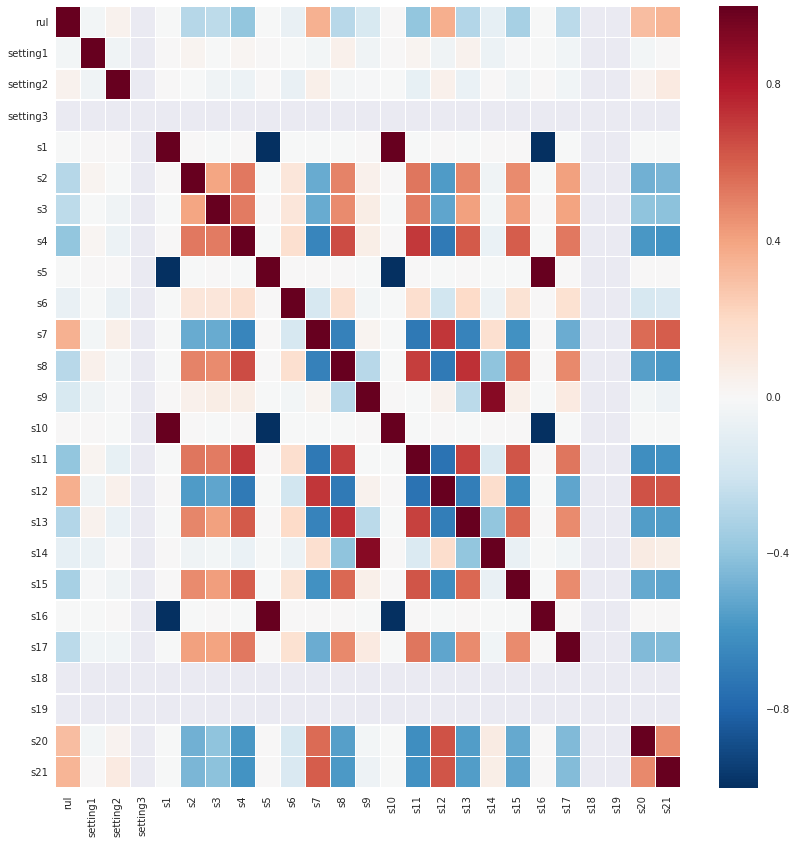

In [11]:
  dims = (14,14)
  fig, ax = plt.subplots(figsize=dims)
sns.heatmap(pf_corr,linewidths=.5);


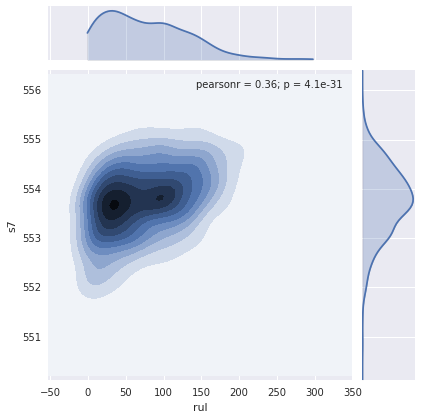

In [12]:
sns.jointplot("rul", "s7", data=pf, kind='kde')  


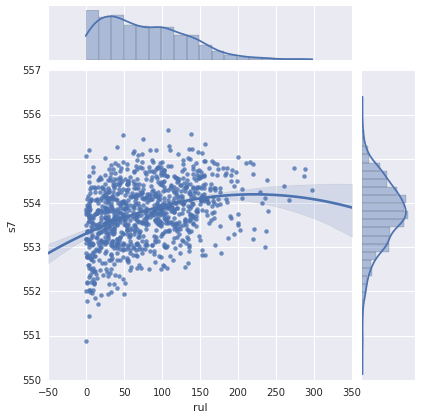

In [13]:
g = sns.JointGrid(x="rul", y="s7", data=pf)  
g.plot_joint(sns.regplot, order=2)  
g.plot_marginals(sns.distplot)  

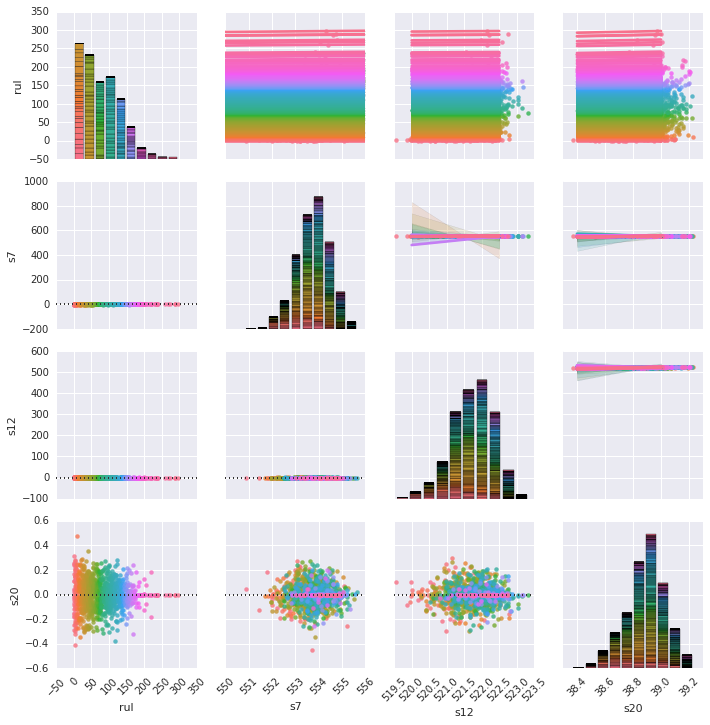

In [14]:
g = sns.PairGrid(pf[["rul", "s7", "s12", "s20"]], hue="rul", dropna=True)  
g.map_upper(sns.regplot)  
g.map_lower(sns.residplot)  
g.map_diag(plt.hist)  
for ax in g.axes.flat:  
    plt.setp(ax.get_xticklabels(), rotation=45)
g.set(alpha=0.5)  

# The sensor data does not show any trends over time, making it difficult to make predictions about the future from the observed data


In [15]:
fraction = 1000.0 / scaledDF.count()
pf2 = scaledDF.sample(fraction=fraction, withReplacement=False, seed=123456).toPandas()



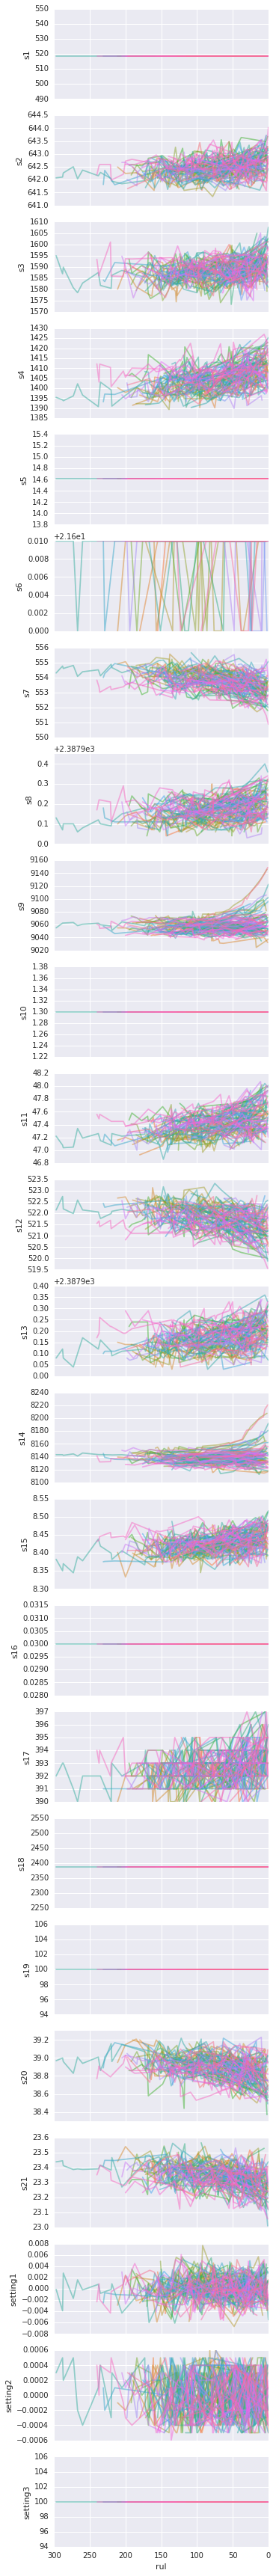

In [16]:

g = sns.PairGrid(data=pf2,
                 x_vars=dependent_var,
                 y_vars=sensor_measure_columns_names + \
                        operational_settings_columns_names,
                 hue="id", size=2, aspect=2.5)
g = g.map(plt.plot, alpha=0.5)
g = g.set(xlim=(300,0))
#g = g.add_legend()

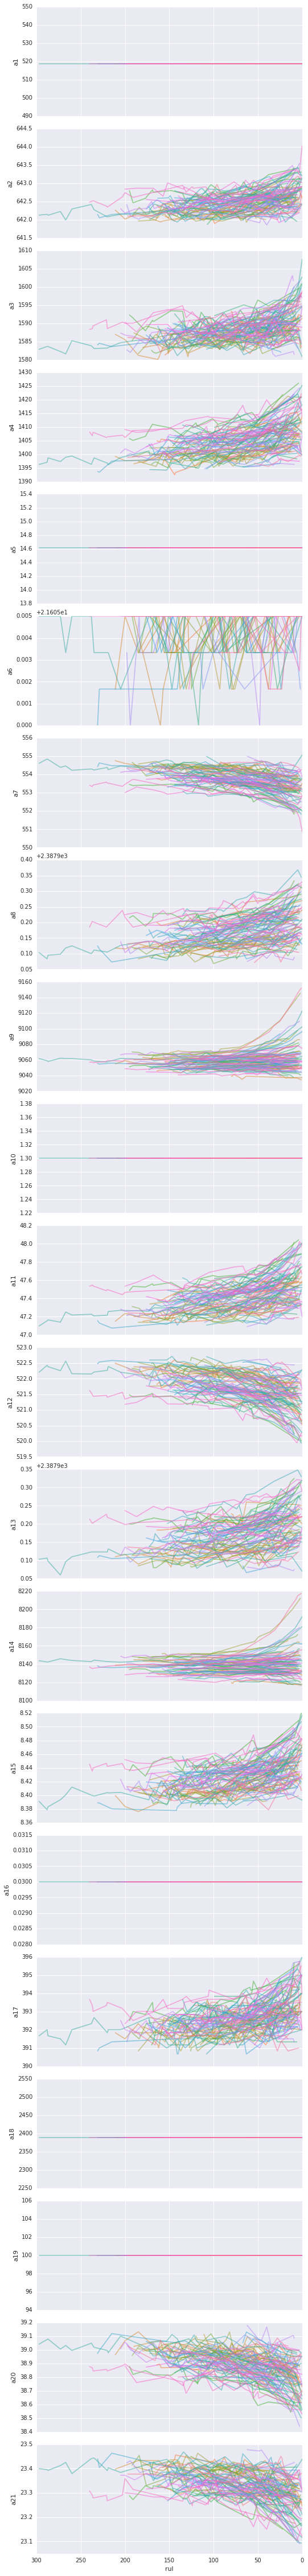

In [17]:

g = sns.PairGrid(data=pf2,
                 x_vars=dependent_var,
                 y_vars=sensor_measure_meancolumns_names,
                 hue="id", size=3, aspect=2.5)
g = g.map(plt.plot, alpha=0.5)
g = g.set(xlim=(300,0))


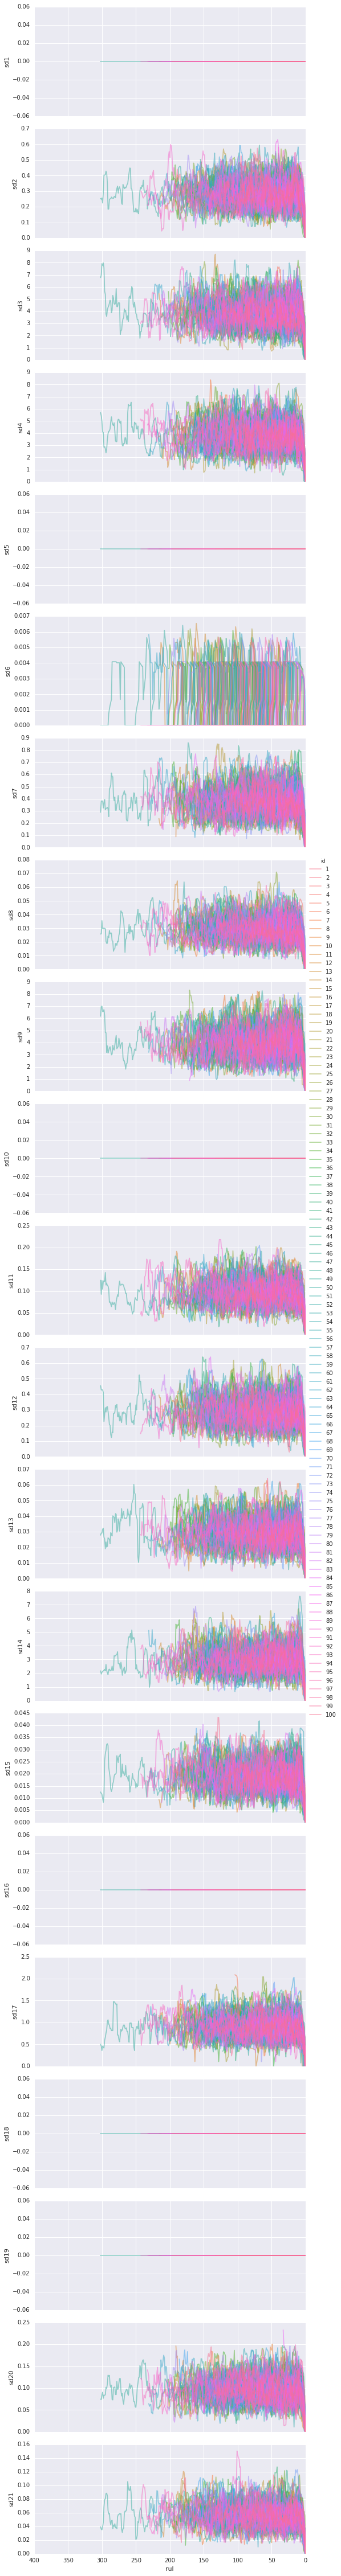

In [18]:

g = sns.PairGrid(data=scaledDF.toPandas(),
                 x_vars=dependent_var,
                 y_vars=sensor_measure_sdeccolumns_names,
                 hue="id", size=3, aspect=2.5)
g = g.map(plt.plot, alpha=0.5)
g = g.set(xlim=(400,0))
g = g.add_legend()

# The sensor measurements happen in 6 clusters; this open investigation coincides with the operating modes


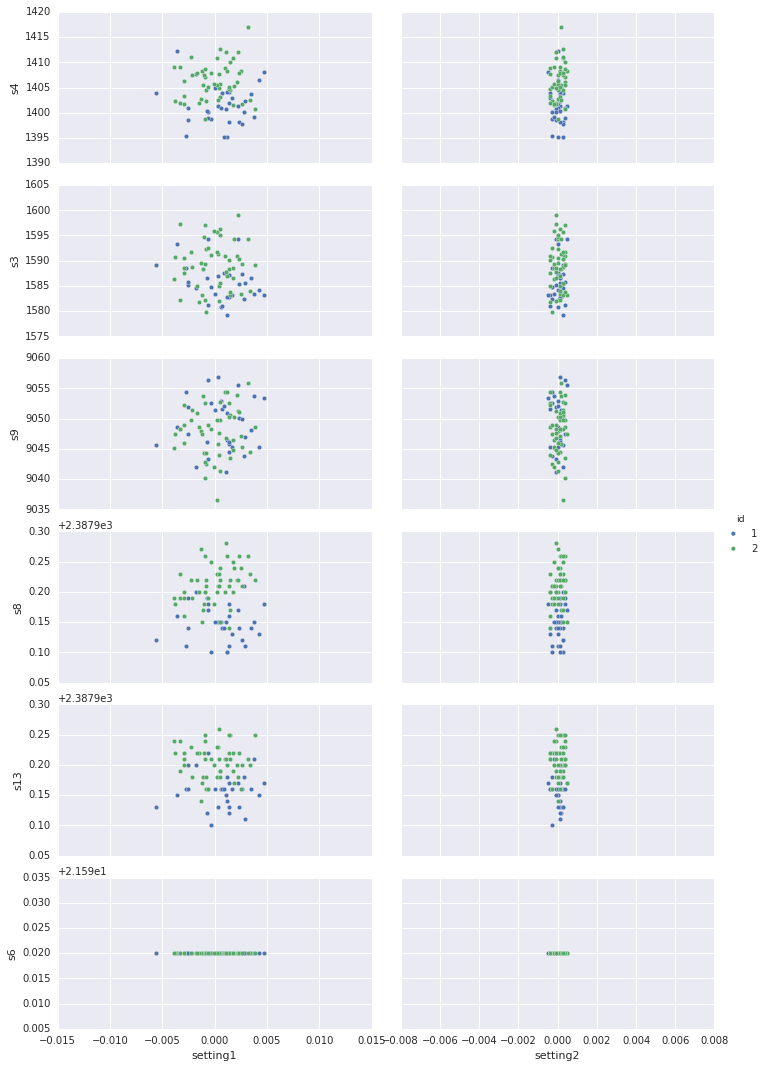

In [19]:

g = sns.pairplot(data=scaledDF.filter(scaledDF.id < 3).toPandas(),
                 x_vars=["setting1","setting2"],
                 y_vars=["s4", "s3", 
                         "s9", "s8", 
                         "s13", "s6"],
                 hue="id", aspect=2)

Use Logistic Regression, [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) Limited-memory BFGS (L-BFGS or LM-BFGS) is an optimization algorithm in the family of quasi-Newton methods that approximates the Broyden–Fletcher–Goldfarb–Shanno (BFGS) algorithm using a limited amount of computer memory. It is a popular algorithm for parameter estimation in machine learning version is implemented under [LogisticRegressionWithLBFGS](http://spark.apache.org/docs/latest/api/scala/index.html#org.apache.spark.mllib.classification.LogisticRegressionWithLBFGS), and this version supports both binary and multinomial Logistic Regression while SGD version only supports binary Logistic Regression. However, L-BFGS version doesn’t support L1 regularization but SGD one supports L1 regularization. When L1 regularization is not required, L-BFGS version is strongly recommended since it converges faster and more accurately compared to SGD by approximating the inverse Hessian matrix using quasi-Newton method.

In [20]:
from pyspark.mllib.linalg import Vectors, DenseMatrix 
import numpy as np

def display_cm(m):
  a = m.toArray()
  #print(a)
  #print(m)
  row_sums = a.astype(np.float64).sum(axis=1).astype(np.float64)
  percentage_matrix = 100.0* a.astype(np.float64) / row_sums[:, np.newaxis]
  #print(percentage_matrix)
  plt.figure(figsize=(3, 3))
  dims = (8,8)
  fig, ax = plt.subplots(figsize=dims)
  sns.heatmap(percentage_matrix, annot=True,  fmt='.2f', xticklabels=['0' ,'1','2'], yticklabels=['0' ,'1','2']);
  plt.title('Confusion Matrix');


In [21]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col
from pyspark.sql import SQLContext



def runmodel(model,data):
    # load the model
    ## trained with one data
    ## trained with all data
    lgregWithLBFGS = LogisticRegressionModel.load(sc, model)
    
    # load data for testset FD001DF 
    scaleddftest_FDDF = sqlContext.read.parquet(data)
    print("scaleddftest_FDDF count = %s" % scaleddftest_FDDF.count())
    
    # Index labels, adding metadata to the label column.
    #Fit on whole dataset to include all labels in index.
    indexer = StringIndexer(inputCol="label2", outputCol="indexedLabel")
    indexedDF = indexer.fit(scaleddftest_FDDF).transform(scaleddftest_FDDF)
    print("indexedDF count = %s" % indexedDF.count())
    labeledRDD = indexedDF.select(col("indexedLabel").alias("label"), col("scaledFeatures").alias("features")).map(lambda row:  LabeledPoint(row.label, row.features))
        
    # Compute raw scores on the test set
    predictionAndLabels = labeledRDD.map(lambda lp: (float(lgregWithLBFGS.predict(lp.features)), lp.label))
    # Instantiate metrics object
    metrics = MulticlassMetrics(predictionAndLabels)
    # Overall statistics
    precision = metrics.precision()
    recall = metrics.recall()
    f1Score = metrics.fMeasure()
    print("Summary Stats")
    print("Precision = %s" % precision)
    print("Recall = %s" % recall)
    print("F1 Score = %s" % f1Score)
    # Statistics by class SF
    labels = labeledRDD.map(lambda lp: lp.label).distinct().collect()
    for label in sorted(labels):
        print("Class %s precision = %s" % (label, metrics.precision(label)))
        print("Class %s recall = %s" % (label, metrics.recall(label)))
        print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
    # Weighted stats
    print("Weighted recall = %s" % metrics.weightedRecall)
    print("Weighted precision = %s" % metrics.weightedPrecision)
    print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
    print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
    print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)
    df_confusion = metrics.confusionMatrix()
    print (df_confusion)
    display_cm(df_confusion);

In [24]:
runmodel("/share/tedsds/savedmodelMulticlassMetricsExamplesaved","/share/tedsds/output")


Py4JJavaError: An error occurred while calling z:org.apache.spark.mllib.classification.LogisticRegressionModel.load.
: org.apache.hadoop.mapred.InvalidInputException: Input path does not exist: hdfs://sandbox.hortonworks.com:8020/share/tedsds/savedmodelMulticlassMetricsExamplesaved/metadata
	at org.apache.hadoop.mapred.FileInputFormat.singleThreadedListStatus(FileInputFormat.java:287)
	at org.apache.hadoop.mapred.FileInputFormat.listStatus(FileInputFormat.java:229)
	at org.apache.hadoop.mapred.FileInputFormat.getSplits(FileInputFormat.java:315)
	at org.apache.spark.rdd.HadoopRDD.getPartitions(HadoopRDD.scala:199)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:239)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:237)
	at scala.Option.getOrElse(Option.scala:120)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:237)
	at org.apache.spark.rdd.MapPartitionsRDD.getPartitions(MapPartitionsRDD.scala:35)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:239)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:237)
	at scala.Option.getOrElse(Option.scala:120)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:237)
	at org.apache.spark.rdd.RDD$$anonfun$take$1.apply(RDD.scala:1293)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:316)
	at org.apache.spark.rdd.RDD.take(RDD.scala:1288)
	at org.apache.spark.rdd.RDD$$anonfun$first$1.apply(RDD.scala:1328)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:316)
	at org.apache.spark.rdd.RDD.first(RDD.scala:1327)
	at org.apache.spark.mllib.util.Loader$.loadMetadata(modelSaveLoad.scala:129)
	at org.apache.spark.mllib.classification.LogisticRegressionModel$.load(LogisticRegression.scala:175)
	at org.apache.spark.mllib.classification.LogisticRegressionModel.load(LogisticRegression.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:57)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:606)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:381)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:209)
	at java.lang.Thread.run(Thread.java:745)


In [ ]:
runmodel("/share/tedsds/savedmodelallMulticlassMetricsExamplesaved","/share/tedsds/scaleddftest_FD001")


Because there are three target category values, this is a 3-×-3 matrix, where each row corresponds to an actual correct value, and each column to a predicted value, in order.  The entry at row i and column j counts the number of times an example with true category i was predicted as category j. So, the correct predictions are the counts along the diagonal, and incorrect predictions are everything else. Counts are high along the diagonal, which is good. However, there are certainly a number of misclassifications. [7]

It’s helpful to summarize the accuracy with a single number. An obvious place to start is to compute the fraction of all examples that were correctly predicted:
   
```
Precision = 0.834012714126
Weighted precision = 0.890728479604

```

About 83% of examples were classified correctly. 

This measurement is commonly called accuracy, and is called precision in Spark’s MulticlassMetrics. This is a light overloading of the term. Precision is actually a common metric for binary classification problems, where there are two category values, not several. In a binary classification problem, where there is some kind of positive and negative class, precision is the fraction of examples that the classifier marked positive that are actually positive. [7]

### What does this mean in this context? 

We are 83% successful in finding when label2 should be 0 (all OK) and 86% successful finding when label2 should be 1 (30 cyckles within breakdown) and 17% successful in telling when label2 should be 2 (15
cyckles within breakdown)

<img src="https://az712634.vo.msecnd.net/samplesimg/v1/T4/labeling_1.png" alt="Drawing" style="width: 400px;"/>



![img](http://dni-institute.in/blogs/wp-content/uploads/2015/02/ConfusionMatrix.png)

In [ ]:
import numpy as np
        
class ROC_Point(object):
    def __init__(self,actual,predicted):
        ''' Method to initialize a ROC Curve with an observation'''
        self.true_positive = 0
        self.true_negative = 0
        self.false_positive= 0
        self.false_negative= 0        
        if actual and predicted:
            self.true_positive = 1
        elif not actual and not predicted:
            self.true_negative = 1
        elif not actual and  predicted:
            self.false_positive= 1
        elif actual and not predicted:
            self.false_negative= 1   
 
    def ROC_add(self, ROC_Point):    
        ''' Method to aggregate ROC Curve'''
        self.true_positive  += ROC_Point.true_positive
        self.true_negative  += ROC_Point.true_negative
        self.false_positive += ROC_Point.false_positive
        self.false_negative += ROC_Point.false_negative
        return self
    def printme(self):
        print 'true_positive ... ' + str(self.true_positive) + '\n'
        print 'true_negative ... ' + str(self.true_negative) + '\n'
        print 'false_positive... ' + str(self.false_positive) + '\n'
        print 'false_negative ...' + str(self.false_negative) + '\n';
 
ROC_Point(True,True) 

def runmodel2(model,data):
    # load the model
    ## trained with one data
    ## trained with all data
    lgregWithLBFGS = LogisticRegressionModel.load(sc, model)
    
    # load data for testset FD001DF 
    scaleddftest_FDDF = sqlContext.read.parquet(data)
    print("scaleddftest_FDDF count = %s" % scaleddftest_FDDF.count())
    
    # Index labels, adding metadata to the label column.
    #Fit on whole dataset to include all labels in index.
    indexer = StringIndexer(inputCol="label2", outputCol="indexedLabel")
    indexedDF = indexer.fit(scaleddftest_FDDF).transform(scaleddftest_FDDF)
    print("indexedDF count = %s" % indexedDF.count())
    labeledRDD = indexedDF.select(col("indexedLabel").alias("label"), col("scaledFeatures").alias("features")).map(lambda row:  LabeledPoint(row.label, row.features))
        
    # Compute raw scores on the test set
    predictionAndLabels = labeledRDD.map(lambda lp: (float(lgregWithLBFGS.predict(lp.features)), lp.label))
    # Instantiate metrics object
    metrics = MulticlassMetrics(predictionAndLabels)
    # Overall statistics
    precision = metrics.precision()
    recall = metrics.recall()
    f1Score = metrics.fMeasure()
    print("Summary Stats")
    print("Precision = %s" % precision)
    print("Recall = %s" % recall)
    print("F1 Score = %s" % f1Score)
    # Statistics by class SF
    labels = labeledRDD.map(lambda lp: lp.label).distinct().collect()
    for label in sorted(labels):
        print("Class %s precision = %s" % (label, metrics.precision(label)))
        print("Class %s recall = %s" % (label, metrics.recall(label)))
        print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
    # Weighted stats
    print("Weighted recall = %s" % metrics.weightedRecall)
    print("Weighted precision = %s" % metrics.weightedPrecision)
    print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
    print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
    print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)
    df_confusion = metrics.confusionMatrix()
    display_cm(df_confusion)
    operating_threshold_bc = sc.broadcast(np.arange(0,1,.001))
    labelsAndPreds_Points = predictionAndLabels.map(lambda (label,prediction):  [ROC_Point(label==1,prediction>threshold)
    for threshold in operating_threshold_bc.value])
    labelsAndPreds_ROC_reduced = labelsAndPreds_Points.reduce( lambda l1,l2:  [ ROC_1.ROC_add(ROC_2) for ROC_1,ROC_2 in zip(l1,l2) ] )
    import matplotlib.pyplot as plt
    plt.plot(x,y,'ro')
    plt.plot(np.arange(0,1,.001),np.arange(0,1,.001), 'g-')
    plt.title('ROC Curve - TP rate vs. FP rate' )
    plt.show()

        


In [ ]:
runmodel2("/share/tedsds/savedmodelallMulticlassMetricsExamplesaved","/share/tedsds/scaleddftrain_FD001")

